In [6]:
# import matplotlib.pyplot as plt
import openslide
from pathlib import Path
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
from skimage import transform, color, filters, feature
from skimage.feature import ORB, match_descriptors
from skimage.transform import AffineTransform, warp
from skimage.measure import ransac
from copy import deepcopy
%matplotlib widget
import matplotlib.pyplot as plt

In [7]:
!pip install ipympl

In [8]:
files = [os.path.join(root, file)
         for root, dirs, files in os.walk('thumbnails256')
         for file in files if file.endswith('.npy')]
files.sort()

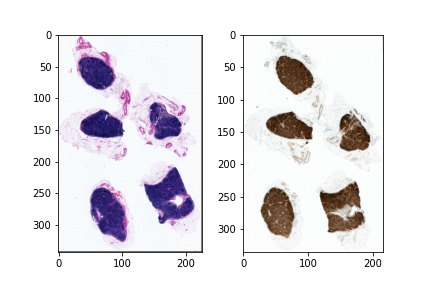

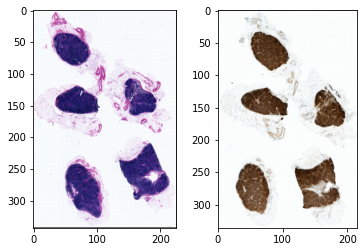

In [9]:
hne = np.load(files[981])
ihc = np.load(files[1034])
ihc = transform.rotate(ihc, 180, resize=False)
plt.subplot(121).imshow(hne)
plt.subplot(122).imshow(ihc)
plt.show()

In [ ]:
hne_gray = color.rgb2gray(hne)
ihc_gray = color.rgb2gray(ihc)
plt.subplot(121).imshow(hne_gray)
plt.subplot(122).imshow(ihc_gray)
plt.show()

hne_edges = feature.canny(hne_gray)
ihc_edges = feature.canny(ihc_gray)
plt.subplot(121).imshow(hne_edges)
plt.subplot(122).imshow(ihc_edges)
plt.show()

In [ ]:
def register(
             src_im,
             dst_im,
             n_keypoints=200,
             fast_threshold=0.05,
             min_samples=3,
             residual_threshold=2,
             max_trials=100,
):
    orb = ORB(n_keypoints=n_keypoints, fast_threshold=fast_threshold)
    orb.detect_and_extract(dst_im)
    keypoints1 = orb.keypoints
    descriptors1 = orb.descriptors

    orb.detect_and_extract(src_im)
    keypoints2 = orb.keypoints
    descriptors2 = orb.descriptors

    # Match descriptors between images
    matches = match_descriptors(descriptors1, descriptors2, cross_check=True)

    # Select matched keypoints
    src = keypoints2[matches[:, 1]][:, ::-1]
    dst = keypoints1[matches[:, 0]][:, ::-1]

    # Perform robust affine transformation
    model_robust, _ = ransac(
                                    (src, dst),
                                    AffineTransform,
                                    min_samples=min_samples,
                                    residual_threshold=residual_threshold,
                                    max_trials=max_trials,
    )
    
    return model_robust

def warp_register(dst_im, model, scale=1):
    model_cpy = deepcopy(model)
    model_cpy.params[0, 2] *= scale
    model_cpy.params[1, 2] *= scale
    im_opt = warp(dst_im, model_cpy.inverse, mode='symmetric')
    return im_opt

In [ ]:
# model = register(ihc_gray, hne_gray, n_keypoints)
model = register(
             ihc_gray,
             hne_gray,
             n_keypoints=1000,
             fast_threshold=0.05,
             min_samples=3,
             residual_threshold=2,
             max_trials=1000,
)
ihc_image_registered = warp_register(ihc_image, model)

# Display the registered image
plt.subplot(131).imshow(hne, cmap='gray')
plt.subplot(132).imshow(ihc_image_registered, cmap='gray')
plt.subplot(133).imshow(ihc, cmap='gray')
plt.tight_layout()
plt.show()

In [ ]:
files32 = [os.path.join(root, file)
         for root, dirs, files in os.walk('thumbnails32')
         for file in files if file.endswith('.png')]
files32.sort()
hne32 = plt.imread(files32[981])
ihc32 = plt.imread(files32[1034])
ihc32 = transform.rotate(ihc32, 180, resize=False)

In [ ]:
ihc_image_registered32 = warp_register(ihc32, model, scale=8)

plt.subplot(131).imshow(hne32, cmap='gray')
plt.subplot(132).imshow(ihc_image_registered32, cmap='gray')
plt.subplot(133).imshow(ihc32, cmap='gray')
plt.tight_layout()
plt.show()